In [1]:
from __future__ import division
import pandas as pd
import json
import requests
import datetime
import dateutil
import matplotlib.pyplot as plt
% matplotlib inline
kph_to_mph_conversion_factor = 0.621371
liters_to_gallons_conversion_factor = 0.264172

In [2]:
def get_json_data(url, auth_token, max_results=None, **kwargs):
    """Fetch and parse json data from a url
    
    This function makes an API call to `url` using the authentication
    token `auth_token`. A maximum number of results can be specified.
    If `max_results` is not specified, all results will be fetched.
    The json responses are parsed and returned as a dict.
    
    Args:
        url (str): A url that implements the automatic list API as described at
                   https://developer.automatic.com/api-reference/#rest-api
        auth_token (str): An oauth authentication token
        max_results (int): A maximum amount of results
        kwargs: Remaining keyword arguments are used as parameters
                in the API request
    
    Returns:
        dict: Contains the parsed json results of the API call(s)
    """
    max_results_per_request = 250
    if max_results:
        num_requests_needed = max_results // max_results_per_request + 1
        results_per_request = max_results // num_requests_needed
        if max_results % num_requests_needed != 0:
            results_per_request += 1
        kwargs['limit'] = results_per_request
    elif 'limit' not in kwargs:
        kwargs['limit'] = max_results_per_request
                
    response_json = get_one_json_page(url, auth_token, **kwargs)
    next_page_url = response_json['_metadata']['next']
    results = response_json['results']
    
    if max_results:
        return results
    
    while next_page_url is not None:
        response_json = get_one_json_page(next_page_url, auth_token, **kwargs)
        next_page_url = response_json['_metadata']['next']
        results.extend(response_json['results'])
        if max_results and len(results) > max_results:
            break
    
    if max_results:
        results = results[:max_results]
    return results

def get_one_json_page(url, auth_token, **kwargs):
    headers = {'Authorization': 'Bearer {}'.format(auth_token)}
    response = requests.get(url, headers=headers, params=kwargs)
    response.raise_for_status()
    return response.json()

In [3]:
def get_summary(auth_token, start_date=None, end_date=None):
    """Get a summary of all the trips associated with an authentication token
    
    Args:
        auth_token (str): An oauth authentication token
        start_date (datetime): Only trips started on or after `start_date`
                               will be included in the summary
        end_date (datetime): Only trips started on or before `end_date`
                             will be included in the summary
        
    Returns:
        dict: Contains an overall summary, a per vehicle summary, and a per weekday
              summary of the trips associated with `auth_token` within the specified range
    """
    range_params = {}
    if start_date:
        seconds_start = (start_date - datetime.datetime(1970,1,1)).total_seconds()
        range_params['started_at__gte'] = int(seconds_start)
    if end_date:
        seconds_end = (end_date - datetime.datetime(1970,1,1)).total_seconds()
        range_params['started_at__lte'] = int(seconds_end)
    trip_url = 'https://api.automatic.com/trip/'
    json_trip_data = get_json_data(trip_url, auth_token, **range_params)
    trip_df = pd.DataFrame(json_trip_data)
    vehicle_url = 'https://api.automatic.com/vehicle'
    json_vehicle_data = get_json_data(vehicle_url, auth_token)
    vehicle_df = pd.DataFrame(json_vehicle_data)
    summary = {}
    summary['overall_summary'] = get_trip_summary(trip_df)
    summary.update(get_per_vehicle_summary(trip_df, vehicle_df))
    summary.update(get_per_day_of_week_summary(trip_df))
    summary.update(get_per_tag_summary(trip_df))
    return summary

In [4]:
def get_per_vehicle_summary(trip_df, vehicle_df):
    """Generate a per_vehicle summary from the trip entries in the dataframe
    
    Args:
        trip_df (pandas.DataFrame): A data frame containing information for 
                                    different trips on each row. Each row must contain
                                    the fields from automatic's trip object as described
                                    at https://developer.automatic.com/api-reference/#api-objects
        vehicle_df (pandas.DataFrame): A data frame containing information for 
                                       different vehicles on each row. Each row must contain
                                       the fields from automatic's vehicle object as described
                                       at https://developer.automatic.com/api-reference/#api-objects
                                    
    Returns:
        dict: Contains a per vehicle summary of the trips in trip_df along with
              information about the vehicle if it is available in `vehicle_df`
    """
    
    if len(trip_df) == 0:
        return {}
    
    summary = {}    
    summary['vehicles'] = {}     
    summary['per_vehicle_summaries'] = {}
    for vehicle_url, df in trip_df.groupby('vehicle'):
        summary['per_vehicle_summaries'][vehicle_url] = get_trip_summary(df)
        if vehicle_url not in summary['vehicles']:
            summary['vehicles'][vehicle_url] = {}
    
    # include information for known vehicles
    if len(vehicle_df) != 0:
        vehicle_df = vehicle_df[['url', 'make', 'model', 'submodel', 'year']]
        vehicles = vehicle_df.set_index('url').transpose().to_dict()
        for url in vehicles:
            if url in summary['vehicles']:
                summary['vehicles'][url] = vehicles[url]
            
    return summary

In [5]:
def get_per_day_of_week_summary(trip_df):
    """Generate a per_day_of_week summary from the trip entries in the dataframe
    
    Args:
        trip_df (pandas.DataFrame): A data frame containing information for 
                                    different trips on each row. Each row must contain
                                    the fields from automatic's trip object as described
                                    at https://developer.automatic.com/api-reference/#trip
                                    
    Returns:
        dict: Contains a per day of week summary of the trips in trip_df
    """
    
    if len(trip_df) == 0:
        return {}
    per_day_of_week_summaries = {}
    days_of_week = trip_df.started_at.apply(extract_day_of_week)
    for day_of_week, df in trip_df.groupby(days_of_week):
        per_day_of_week_summaries[day_of_week] = get_trip_summary(df)
    summary = {}
    summary['per_day_of_week_summaries'] = per_day_of_week_summaries
    return summary

def extract_day_of_week(date_string):
    return dateutil.parser.parse(date_string).strftime('%A')

In [6]:
def get_per_tag_summary(trip_df):
    """Generate a per tag summary from the trip entries in the dataframe
    
    Args:
        trip_df (pandas.DataFrame): A data frame containing information for 
                                    different trips on each row. Each row must contain
                                    the fields from automatic's trip object as described
                                    at https://developer.automatic.com/api-reference/#trip
                                    
    Returns:
        dict: Contains a per tag summary of the trips in trip_df
    """
    
    if len(trip_df) == 0:
        return {}
    per_tag_summaries = {}
    tags = set()
    for tag_list in trip_df.tags:
        for tag in tag_list:
            tags.add(tag)
    for tag in tags:
        per_tag_summaries[tag] = get_trip_summary(trip_df[[tag in tag_list for tag_list in trip_df.tags]])
    summary = {}
    summary['per_tag_summaries'] = per_tag_summaries
    return summary

In [7]:
def get_trip_summary(trip_df):
    """Generate a trip summary from the trip entries in the dataframe
    
    Args:
        trip_df (pandas.DataFrame): A data frame containing information for 
                                    different trips on each row. Each row must contain
                                    the fields from automatic's trip object as described
                                    at https://developer.automatic.com/api-reference/#api-objects
                                    
    Returns:
        dict: Contains an overall summary and a per vehicle summary of the
              trips in trip_df
    """
    
    if len(trip_df) == 0:
        return {}
    summary = {}
    summary_functions = [get_basic_trip_summary,
                         get_highway_speeding_fraction_summary,
                         get_vehicle_event_summary]
    for summary_function in summary_functions:
        summary.update(summary_function(trip_df))
    return summary

In [8]:
def get_basic_trip_summary(trip_df):
    """Generate a basic summary from the trip entries in the dataframe
    
    Args:
        trip_df (pandas.DataFrame): A data frame containing information for 
                                    different trips on each row. Each row must contain
                                    the fields from automatic's trip object as described
                                    at https://developer.automatic.com/api-reference/#api-objects
                                    
    Returns:
        dict: Contains a summary of the trip entries in the `trip_df` dataframe.
    """
    
    if len(trip_df) == 0:
        return {}
    summary = {}
    summary['total_num_trips'] = len(trip_df)
    summary['total_duration_mins'] = trip_df.duration_s.sum() / 60
    summary['avg_duration_per_trip_mins'] = trip_df.duration_s.mean() / 60
    distance_miles = trip_df.distance_m / 1000 * kph_to_mph_conversion_factor
    summary['total_miles'] = distance_miles.sum()
    summary['avg_miles_per_trip'] = distance_miles.mean()
    city_miles = distance_miles * trip_df.city_fraction
    summary['total_city_miles'] = city_miles.sum()
    summary['avg_city_miles_per_trip'] = city_miles.mean()
    highway_miles = distance_miles * trip_df.highway_fraction
    summary['total_highway_miles'] = highway_miles.sum()
    summary['avg_highway_miles_per_trip'] = highway_miles.mean()
    trip_gallons = trip_df.fuel_volume_l * liters_to_gallons_conversion_factor
    summary['total_gallons'] = trip_gallons.sum()
    summary['avg_gallons_per_trip'] = trip_gallons.mean()
    summary['avg_mpg_per_trip'] = summary['total_miles'] / summary['total_gallons']
    summary['total_gas_cost'] = trip_df.fuel_cost_usd.sum()
    summary['avg_gas_cost_per_trip'] = trip_df.fuel_cost_usd.mean()
    
    return summary

In [9]:
def get_highway_speeding_fraction_summary(trip_df):
    """Generate a speeding fraction summary from the trip entries in df
    
    Args:
        trip_df (pandas.DataFrame): A data frame containing information for 
                                    different trips on each row. Each row must contain
                                    the fields from automatic's trip object as described
                                    at https://developer.automatic.com/api-reference/#api-objects
                                    
    Returns:
        dict: Contains a summary of the fractions of time spent over the speeds
              of 70, 75, and 80 mph or an empty dict if no highway time
              during the trips
    """
    
    if len(trip_df) == 0:
        return {}
    summary = {}
    highway_duration = (trip_df.duration_s * trip_df.highway_fraction).sum()
    if highway_duration == 0:
        return summary
    summary['fraction_highway_time_over_70'] = (trip_df.duration_over_70_s.sum() / 
                                                highway_duration)
    summary['fraction_highway_time_over_75'] = (trip_df.duration_over_75_s.sum() / 
                                                highway_duration)
    summary['fraction_highway_time_over_80'] = (trip_df.duration_over_80_s.sum() / 
                                                highway_duration)
    return summary

In [10]:
def get_vehicle_event_summary(trip_df):
    """Generate a summary of the events from the trip entries in df
    
    Args:
        trip_df (pandas.DataFrame): A data frame containing information for 
                                    different trips on each row. Each row must contain
                                    the fields from automatic's trip object as described
                                    at https://developer.automatic.com/api-reference/#api-objects
                                    
    Returns:
        dict: Contains a summary of three types of vehicle events:
              hard brakes, hard accelerations, and speeding. If there are
              no events, the dict will be empty
    """
    
    if len(trip_df) == 0:
        return {}
    max_speed = 0
    sum_speed_duration_product = 0
    sum_speeding_duration = 0
    sum_gforce_brake = 0
    count_gforce_brake = 0
    max_gforce_brake = 0
    sum_gforce_accel = 0
    count_gforce_accel = 0
    max_gforce_accel = 0
    summary = {}
    for vehicle_event_list in trip_df.vehicle_events:
        for event in vehicle_event_list:
            if event['type'] == 'hard_brake':
                if event['g_force'] > max_gforce_brake:
                    max_gforce_brake = event['g_force']
                sum_gforce_brake += event['g_force']
                count_gforce_brake += 1
            elif event['type'] == 'hard_accel':
                if event['g_force'] > max_gforce_accel:
                    max_gforce_accel = event['g_force']
                sum_gforce_accel += event['g_force']
                count_gforce_accel += 1               
            elif event['type'] == 'speeding':
                event_start = dateutil.parser.parse(event['started_at'])
                event_end = dateutil.parser.parse(event['ended_at'])
                duration = (event_end - event_start).total_seconds()
                if event['velocity_kph'] > max_speed:
                    max_speed = event['velocity_kph']
                sum_speed_duration_product += event['velocity_kph'] * duration
                sum_speeding_duration += duration
    if sum_speeding_duration > 0:
        summary['max_speed_while_speeding_mph'] = max_speed * kph_to_mph_conversion_factor
        summary['avg_speed_while_speeding_mph'] = (sum_speed_duration_product / 
                                                   sum_speeding_duration *
                                                   kph_to_mph_conversion_factor)
    if count_gforce_brake > 0:
        summary['max_gforce_during_hard_brakes'] = max_gforce_brake
        summary['avg_gforce_during_hard_brakes'] = sum_gforce_brake / count_gforce_brake
        
    if count_gforce_accel > 0:
        summary['max_gforce_during_hard_accels'] = max_gforce_accel
        summary['avg_gforce_during_hard_accels'] = sum_gforce_accel / count_gforce_accel
    return summary

In [11]:
auth_token = '65122dde5ab2841a7e11e11ed30dde88ffd3b4c0'
summary = get_summary(auth_token)

In [12]:
import os
from jinja2 import Environment, FileSystemLoader
from IPython.core.display import HTML

In [13]:
PATH = os.getcwd()
TEMPLATE_ENVIRONMENT = Environment(
    autoescape=False,
    loader=FileSystemLoader(os.path.join(PATH, 'templates')),
    trim_blocks=False)
 
 
def render_template(template_filename, context):
    return TEMPLATE_ENVIRONMENT.get_template(template_filename).render(context)

In [14]:
context = {
    'summary': summary
}
HTML(render_template("display_summaries.html", context))

TAG SUMMARY,Overall,business
avg_duration_per_trip_mins,26.2,49.9
avg_speed_while_speeding_mph,70.4,70.0
avg_mpg_per_trip,30.0,34.5
fraction_highway_time_over_70,0.2,0.4
max_gforce_during_hard_accels,0.5,0.3
fraction_highway_time_over_75,0.0,0.0
total_highway_miles,1624.2,417.1
total_city_miles,191.1,18.2
avg_gforce_during_hard_accels,0.3,0.3
avg_highway_miles_per_trip,15.8,37.9


In [15]:
summary_df = pd.DataFrame(summary['overall_summary'], index=[('overall', None)])

for group in summary['per_vehicle_summaries'].keys():
    summary_df = summary_df.append(pd.DataFrame(summary['per_vehicle_summaries'][group], 
                                                index=[('vehicle', group.split('/')[-2][-6:])]))
    
for group in summary['per_day_of_week_summaries'].keys():
    summary_df = summary_df.append(pd.DataFrame(summary['per_day_of_week_summaries'][group], 
                                                index=[('day_of_week', group)]))

for group in summary['per_tag_summaries'].keys():
    summary_df = summary_df.append(pd.DataFrame(summary['per_tag_summaries'][group], 
                                                index=[('tag', group)]))

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


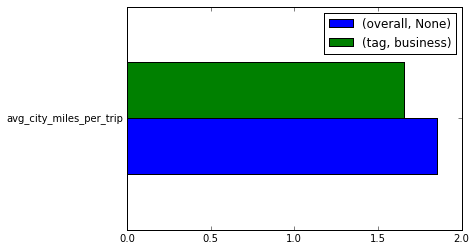

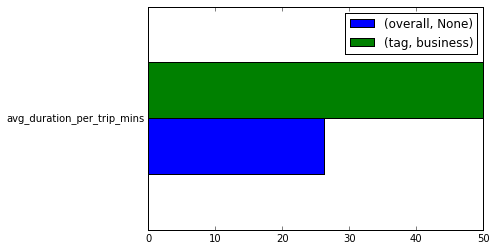

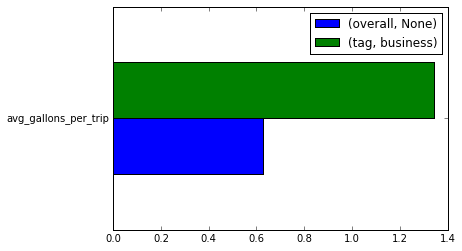

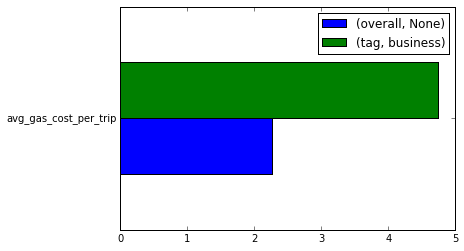

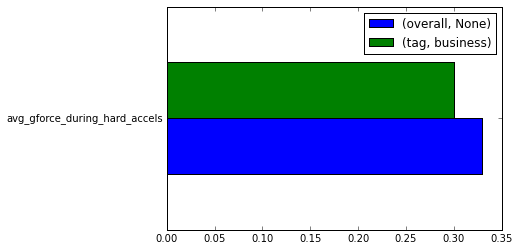

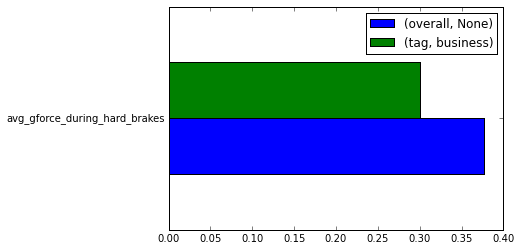

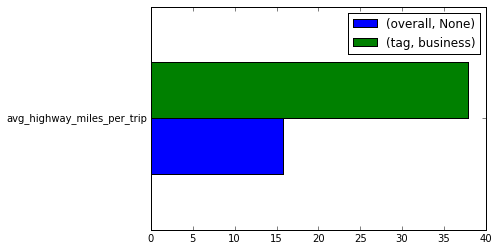

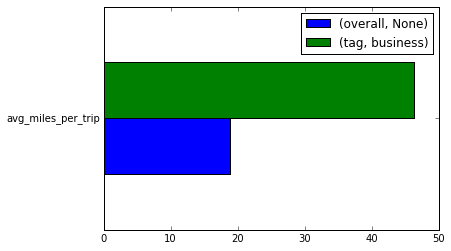

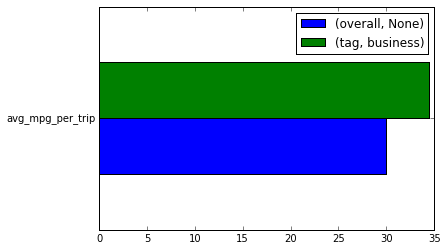

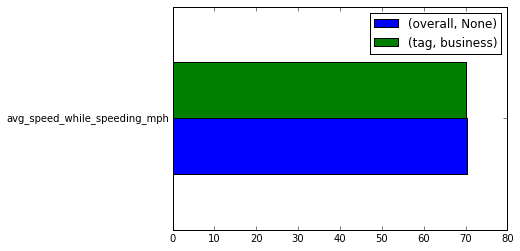

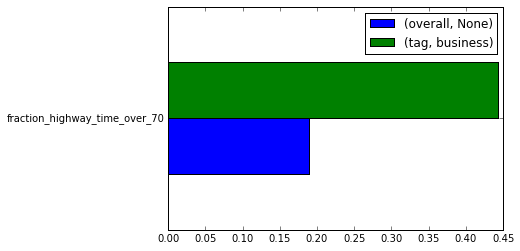

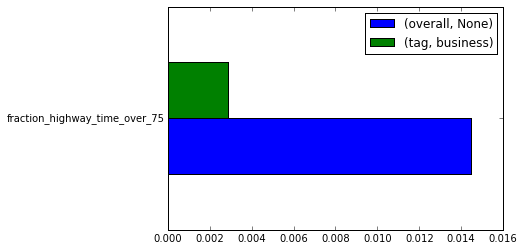

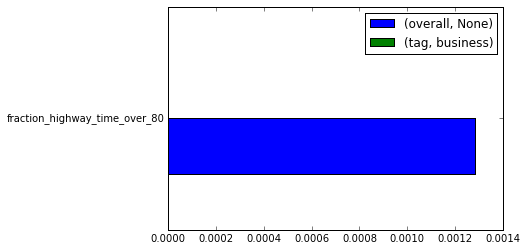

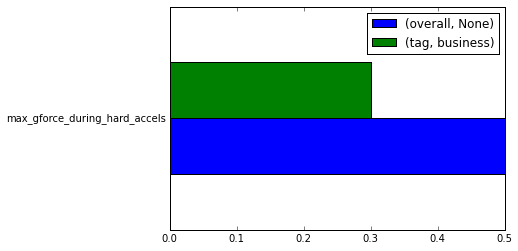

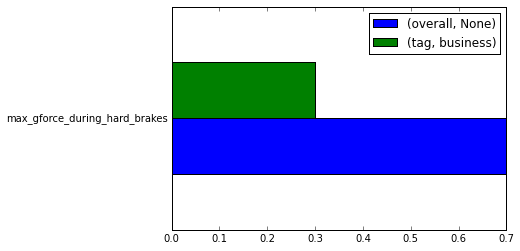

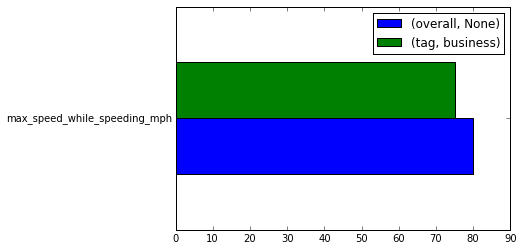

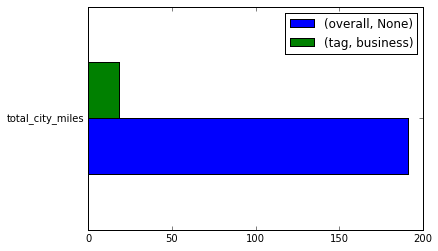

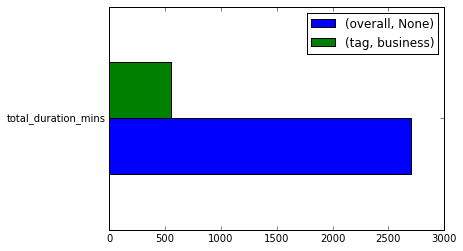

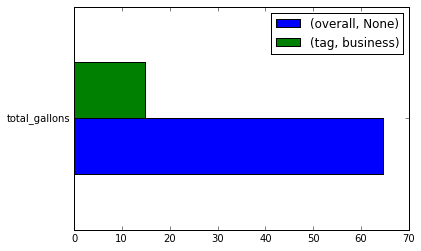

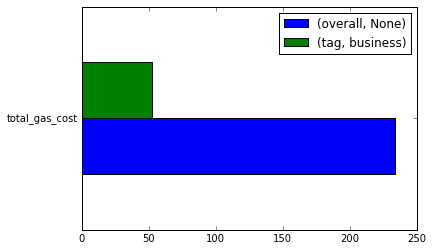

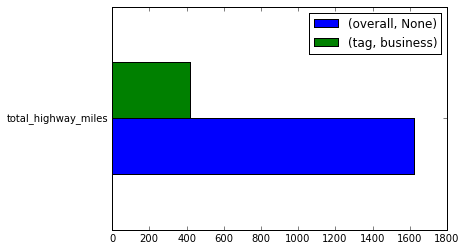

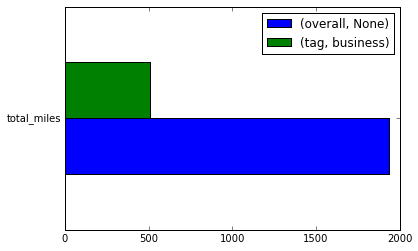

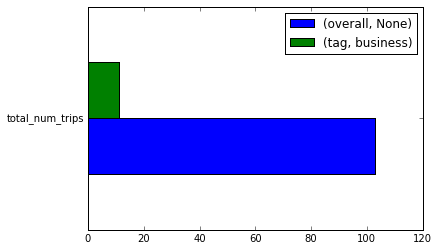

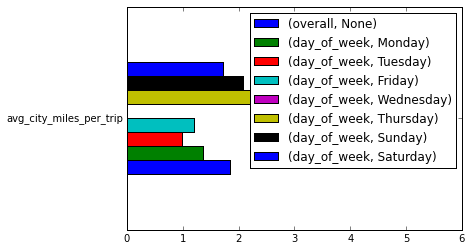

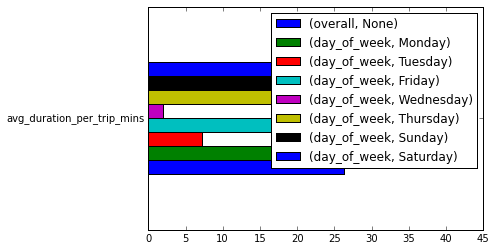

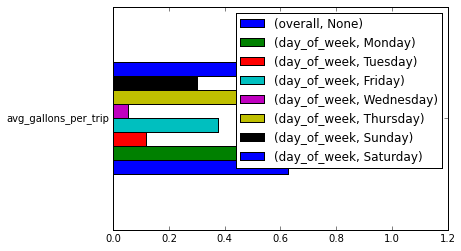

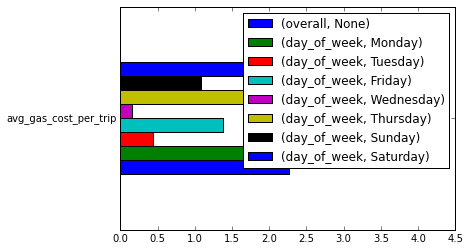

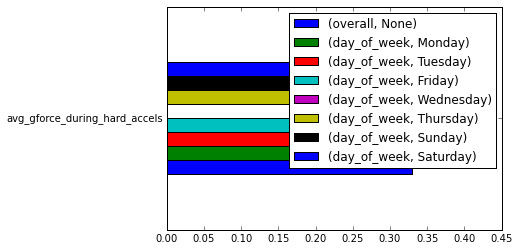

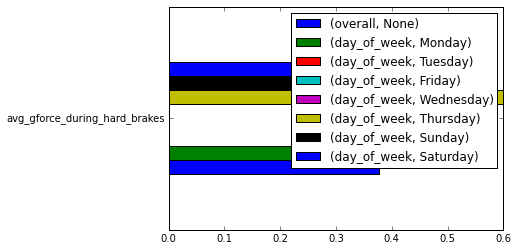

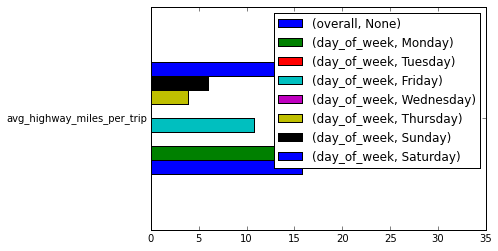

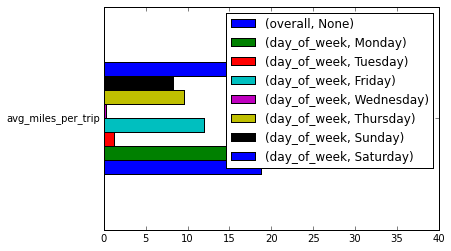

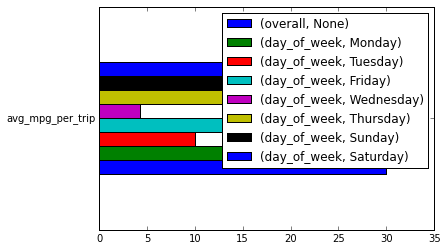

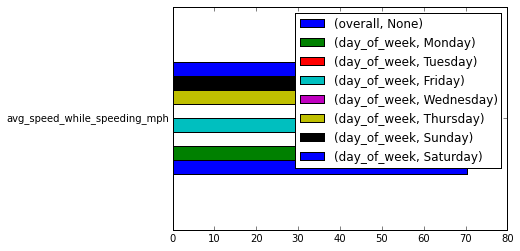

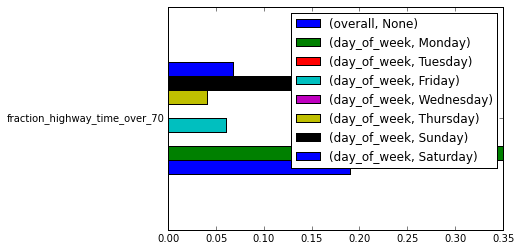

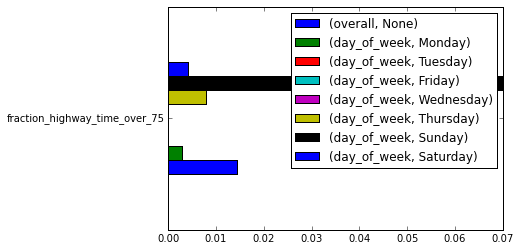

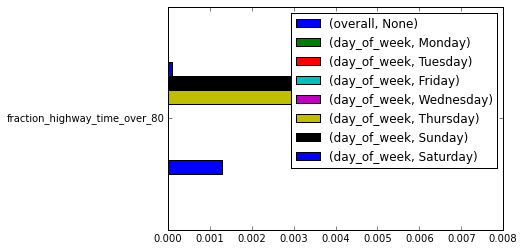

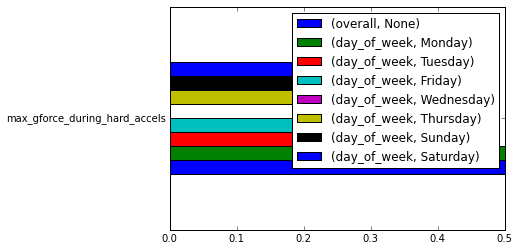

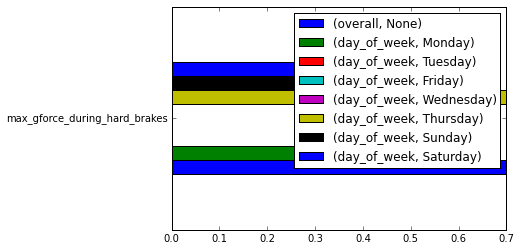

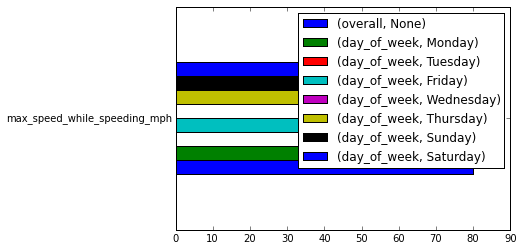

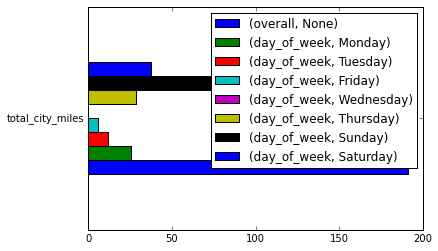

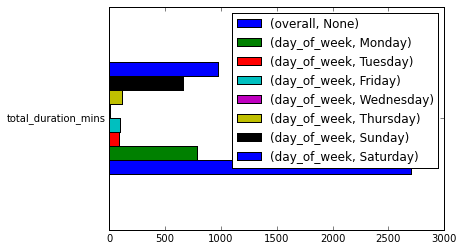

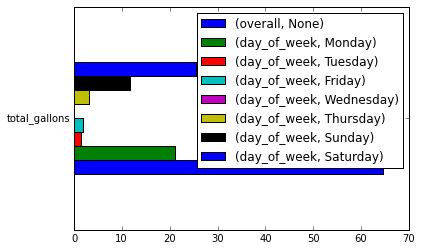

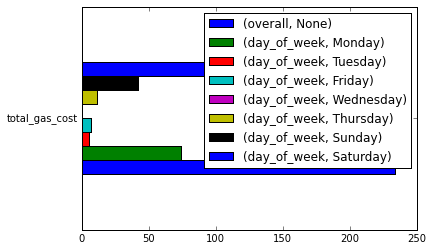

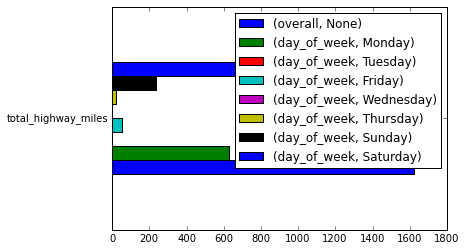

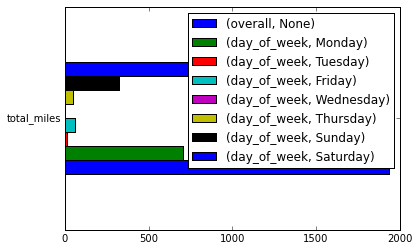

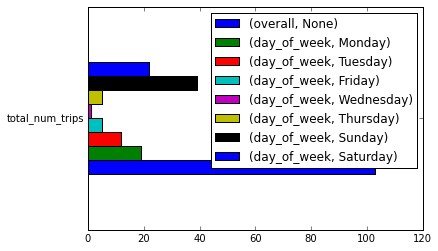

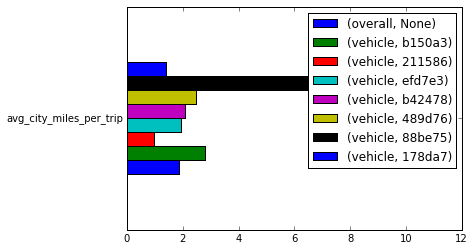

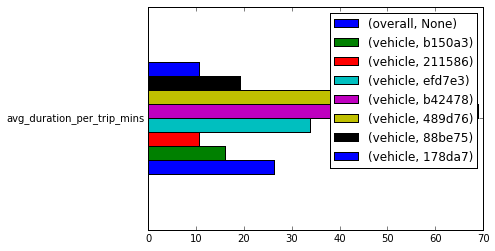

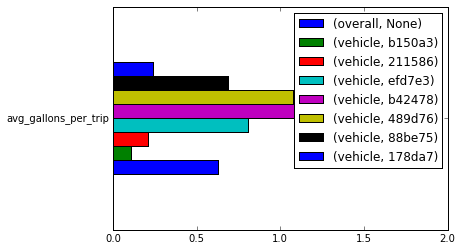

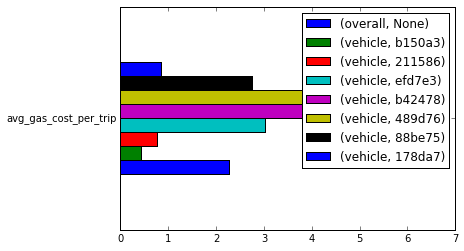

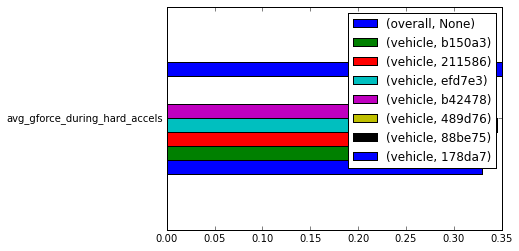

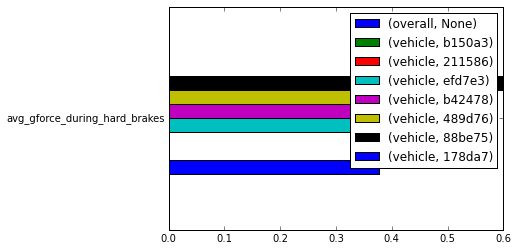

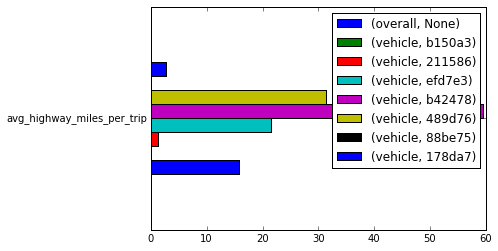

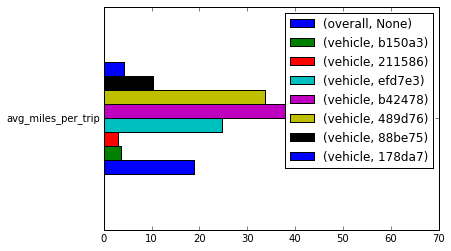

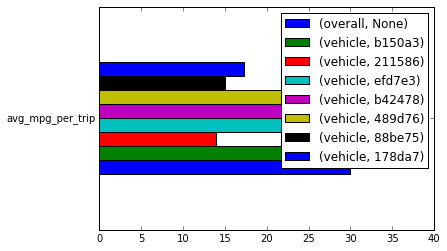

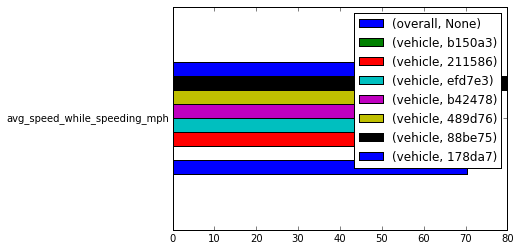

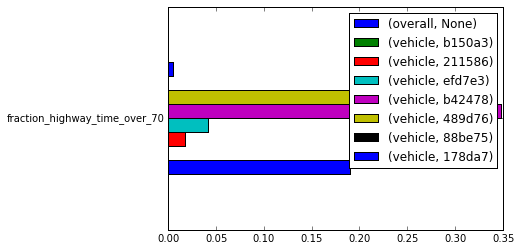

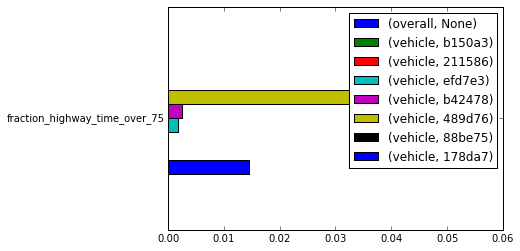

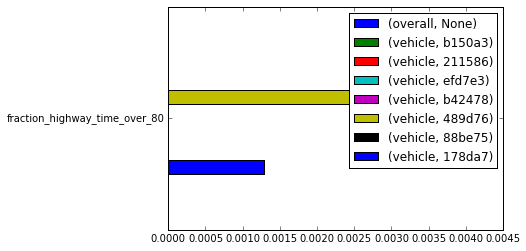

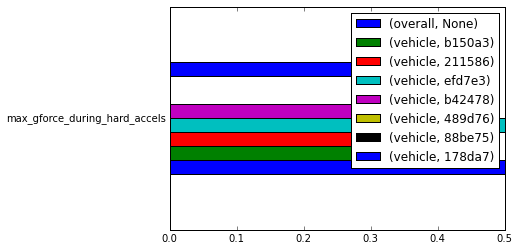

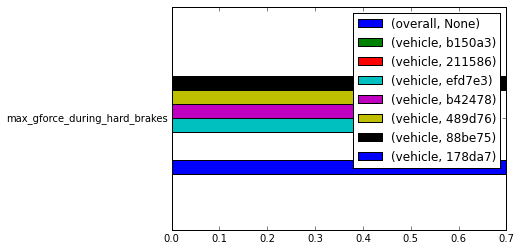

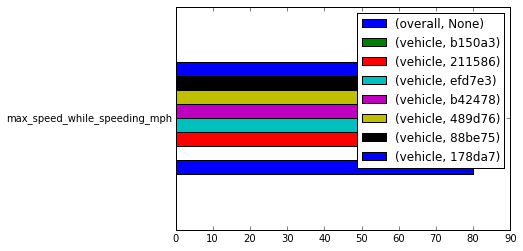

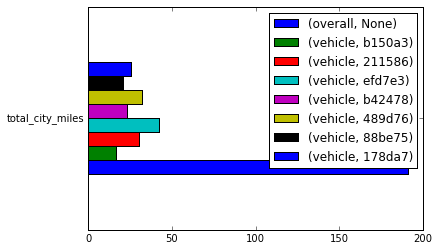

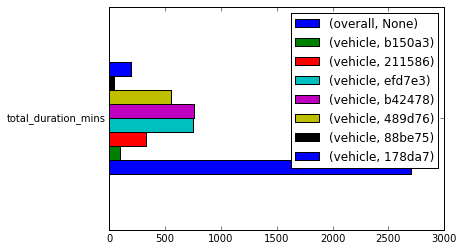

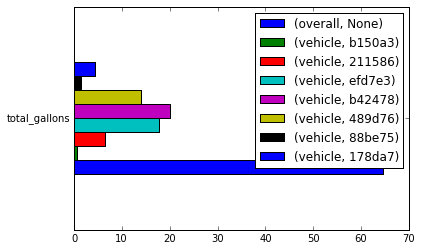

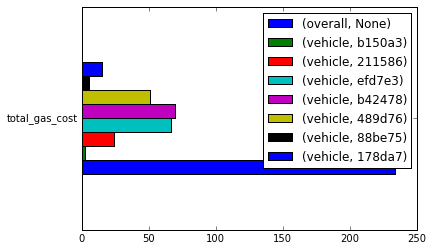

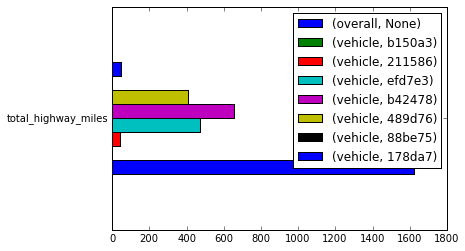

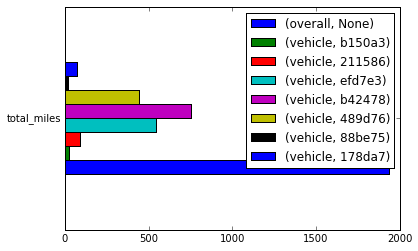

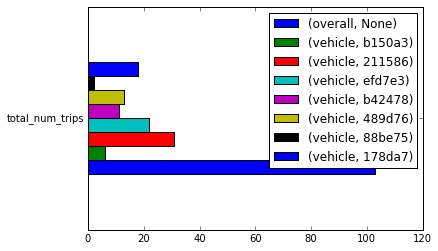

In [16]:
def grouping_function(group):
    def f(x):
        return x[0] == group or x[0] == 'overall'
    return f

groups = ['tag', 'day_of_week', 'vehicle']
for group in groups:
    summ_df = summary_df[summary_df.index.map(grouping_function(group))].transpose()
    for i in xrange(len(summ_df)):
        summ_df.ix[i:i+1,:].plot(kind='barh', legend=True)    